<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/review_processing_2020_02_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
cd '/gdrive/My Drive/abv_reviews'

/gdrive/My Drive/abv_reviews


In [3]:
!pip install -U spacy[cuda100]

     |████████████████████████████████| 10.4MB 84kB/s 
     |████████████████████████████████| 2.2MB 42.5MB/s 
     |████████████████████████████████| 122kB 46.7MB/s 
     |████████████████████████████████| 3.7MB 40.7MB/s 
     |████████████████████████████████| 382.9MB 48kB/s 
  Found existing installation: preshed 2.0.1
    Uninstalling preshed-2.0.1:
      Successfully uninstalled preshed-2.0.1
  Found existing installation: blis 0.2.4
    Uninstalling blis-0.2.4:
      Successfully uninstalled blis-0.2.4
  Found existing installation: thinc 7.0.8
    Uninstalling thinc-7.0.8:
      Successfully uninstalled thinc-7.0.8
  Found existing installation: spacy 2.1.9
    Uninstalling spacy-2.1.9:
      Successfully uninstalled spacy-2.1.9


In [4]:
!pip install textdistance
!pip install "textdistance[extras]"


     |████████████████████████████████| 890kB 7.0MB/s 
     |████████████████████████████████| 143kB 12.8MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for pyxDamerauLevenshtein: filename=pyxDamerauLevenshtein-1.5.3-cp36-cp36m-linux_x86_64.whl size=86809 sha256=b8f29f66b86c59aa69ff61e2d8ef1d36c24f2fe05ddbfee08374cf2e83d2771f
  Stored in directory: /root/.cache/pip/wheels/37/66/2c/863e33407d169ea809ce2908e86556df205dcf5edc4bdd10a5
Successfully built pyxDamerauLevenshtein
  Created wheel for jellyfish: filename=jellyfish-0.7.2-cp36-cp36m-linux_x86_64.whl size=72995 sha256=66988a8c79859e05e856049ed491374472990ca84bacac024715c2baf219f027
  Stored in directory: /root/.cache/pip/wheels/e8/fe/99/d8fa8f2ef7b82a625b0b77a84d319b0b50693659823c4effb4
  Created wheel for python-Levenshtein: fi

In [5]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import random
import srsly
import json
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy import displacy
from spacy.util import minibatch, compounding, decaying
from pandas.io.json import json_normalize
from spacy.gold import docs_to_json, biluo_tags_from_offsets, offsets_from_biluo_tags
from spacy.matcher import Matcher 
from spacy.tokens import Span

import itertools
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [0]:
import textdistance as td
import jellyfish as jf

In [8]:
spacy.prefer_gpu()

True

In [0]:
def cleanse_text(text):
  step1 = re.sub(r"(\{'LOWER':\s)",r"",str(text))
  step2 = re.sub(r"[\[{\'\,\"}\]]",r"",step1)
  return step2

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']

#        print(text, annotations)
        valid_entities = []
        for start, end, label in entities:
          valid_start = start
          valid_end = end
#          print(valid_start, valid_end, len(text))
          while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
            valid_start += 1
          while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
            valid_end -= 1
          valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])

    return cleaned_data

def dump_jsonl(data, output_path, append=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_path))

def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data


def create_entity_pattern(ent_name, ent_label):
  pattern_list = []
  pattern_dict = {}
  id_str = ''
  for word in ent_name.lower().split():
    token_dict = {}
    token_dict['LOWER'] = word
    pattern_list.append(token_dict)
    id_str += '_' + word
  if ent_label[:2] == 'U_':
    pattern_dict['label'] = ent_label[2:]
  else:
    pattern_dict['label'] = ent_label  
  pattern_dict['pattern'] = pattern_list
  if id_str[0] == '_':
    id_str = id_str[1:]
  pattern_dict['id'] = id_str
  return pattern_dict


def clean_like_objects(text):
  step1 = re.sub("ObjectId\(\'","",str(text))
  step2 = re.sub("\'\)","",step1)
  return step2


In [0]:
!cat beverage.jsonl bread.jsonl card_date_event_fac.jsonl > test1.jsonl
!cat condiment.jsonl dish.jsonl event_food_habit.jsonl > test2.jsonl
!cat fruit.jsonl herb_lifestyle_meal.jsonl loc_money_norp_ordinal.jsonl > test3.jsonl
!cat org_product.jsonl pastry_seed_spice.jsonl quant_time.jsonl > test4.jsonl

!cat test1.jsonl test2.jsonl test3.jsonl test4.jsonl > test5.jsonl
!cat test5.jsonl updated_GPE.jsonl partner.jsonl vegetable.jsonl > patterns_2020_02_08.jsonl

In [11]:
!ls -l p*.jsonl

-rw------- 1 root root   13605 Feb  9 15:07 partner.jsonl
-rw------- 1 root root   18045 Dec 26 16:46 pastries_list.jsonl
-rw------- 1 root root   42724 Feb  9 15:07 pastry_seed_spice.jsonl
-rw------- 1 root root    2365 Dec 26 18:11 pattern_bread.jsonl
-rw------- 1 root root    4609 Dec 26 18:11 pattern_condiment.jsonl
-rw------- 1 root root    5397 Dec 26 18:11 pattern_fruit.jsonl
-rw------- 1 root root    3946 Dec 26 18:11 pattern_herb.jsonl
-rw------- 1 root root    1700 Dec 26 18:11 pattern_pastry.jsonl
-rw------- 1 root root 1926737 Feb  1 18:09 patterns_2019_02_01.jsonl
-rw------- 1 root root  529064 Dec 26 14:49 patterns_2019_12_26.jsonl
-rw------- 1 root root  589611 Jan  8 14:35 patterns_2020_01_08.jsonl
-rw------- 1 root root 1833961 Jan 27 08:01 patterns_2020_01_27.jsonl
-rw------- 1 root root 1969569 Jan 28 07:44 patterns_2020_01_28.jsonl
-rw------- 1 root root 2044991 Jan 29 03:37 patterns_2020_01_29.jsonl
-rw------- 1 root root 2022004 Jan 30 16:01 patterns_2020_01_30.js

In [42]:
df_temp = pd.read_json('test5.jsonl',lines=True)
df_temp.head()
df_temp.shape

(9216, 3)

In [12]:
df_pattern = pd.read_json('patterns_2020_02_08.jsonl',lines=True)
df_pattern['cleaned_pattern'] = df_pattern.pattern.apply(lambda x: cleanse_text(x))
df_pattern['label'] = 'U_' + df_pattern.label.astype(str)
df_pattern['tup_col'] = list(zip(df_pattern.cleaned_pattern, df_pattern.label))
df_pattern['merged'] = df_pattern.apply(lambda row: {row['cleaned_pattern']:row['label']}, axis=1)
df_pattern.head()
df_pattern.tail()

,label,pattern,id,cleaned_pattern,tup_col,merged
22511,U_vegetable,[{'LOWER': 'zucchini'}],zucchini,zucchini,"(zucchini, U_vegetable)",{'zucchini': 'U_vegetable'}
22512,U_vegetable,[{'LOWER': 'zucchinis'}],zucchini,zucchinis,"(zucchinis, U_vegetable)",{'zucchinis': 'U_vegetable'}
22513,U_vegetable,[{'LOWER': 'zuccini'}],zucchini,zuccini,"(zuccini, U_vegetable)",{'zuccini': 'U_vegetable'}
22514,U_vegetable,[{'LOWER': 'zuchini'}],zucchini,zuchini,"(zuchini, U_vegetable)",{'zuchini': 'U_vegetable'}
22515,U_vegetable,[{'LOWER': 'zuchinni'}],zucchini,zuchinni,"(zuchinni, U_vegetable)",{'zuchinni': 'U_vegetable'}


In [0]:
ent_list = df_pattern.tup_col.to_list()

In [0]:
nlp = en_core_web_lg.load()

In [15]:
ruler = EntityRuler(nlp).from_disk("patterns_2020_02_08.jsonl")
nlp.add_pipe(ruler, before='ner')
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
nlp.pipe_names

['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [16]:
reviews = pd.read_csv('full_reviews.csv',usecols=['_id', 'createdAt','text',\
                                                  'overall','originality','value','nutrition','presentation','taste',\
                                                  'type','user','user_info.name','user_info.username','user_info.home',\
                                                  'user_info.language','user_info.reviewKarma.total.score',\
                                                  'user_info.likedArticlesCount','user_info.likedReviewsCount',\
                                                  'user_info.followersCount','user_info.challengeReviews',\
                                                  'dish','dish_info.name','type',\
                                                  'restaurant','restaurant_name','restaurant_website','restaurant_country','restaurant_locality',\
                                                  'likes'])
reviews['createdAt'] = pd.to_datetime(reviews['createdAt'],format='%Y-%m-%d %H:%M:%S.%f')

reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92797 entries, 0 to 92796
Data columns (total 28 columns):
_id                                  92797 non-null object
likes                                92797 non-null object
user                                 92797 non-null object
text                                 92797 non-null object
type                                 92797 non-null object
restaurant                           92797 non-null object
dish                                 92797 non-null object
taste                                92797 non-null int64
presentation                         92797 non-null int64
nutrition                            92797 non-null int64
originality                          92797 non-null int64
value                                92797 non-null int64
overall                              92797 non-null float64
createdAt                            92797 non-null datetime64[ns]
user_info.name                       92797 non-null object
us

In [0]:
test_reviews

,_id,likes,user,text,type,restaurant,dish,taste,presentation,nutrition,originality,value,overall,createdAt,user_info.name,user_info.likedArticlesCount,user_info.followersCount,user_info.likedReviewsCount,user_info.challengeReviews,user_info.username,user_info.language,user_info.home,user_info.reviewKarma.total.score,dish_info.name,restaurant_name,restaurant_country,restaurant_website,restaurant_locality
92796,59cb45be92c3c5000471f9a6,[ObjectId('5acb8f9dd5fbb40004e7a793')],599a7f031dc5c80004bc3178,UrbanBites' falafel wrap came lightly toasted ...,dish,59cb26a292c3c5000471f99f,59cb45bc92c3c5000471f9a3,5,5,5,5,4,4.8,2017-09-27 06:31:26.826,Peter Lewis,0,26,4,11,peter,en,Singapore,8,Falafel Wrap,Urban Bites,Singapore,http://www.urbanbites.com.sg/,Singapore


In [0]:
train_reviews = reviews[:3000]
eval_reviews = reviews[3000:92796]
test_reviews = reviews[92796:]

In [0]:
train_gen = (rev for rev in train_reviews['text'])
to_train_ents = []
check_list = []

In [0]:
for raw, doc in zip(list(train_reviews['text']), nlp.pipe(list(train_reviews['text']))):
  tok_list = [token.text for token in doc]
  tag_list = ['O' for token in doc]
  matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]]

  for ent in matched_ents:
    ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
    tag_list[ent[0]] = ent_tag
  entities = offsets_from_biluo_tags(doc, tag_list)
  to_train_ents.append((raw, dict(entities = entities)))
clean_train_ents = trim_entity_spans(to_train_ents)

In [20]:
dump_jsonl(clean_train_ents,'train.jsonl')

Wrote 3000 records to train.jsonl


In [21]:
train_data = load_jsonl('train.jsonl')
type(train_data)

Loaded 3000 records from train.jsonl


list

In [22]:
model = 'en_core_web_lg'
#model = None


"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = en_core_web_lg.load()  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Loaded model 'en_core_web_lg'


In [23]:
ner.labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'GPE_city',
 'GPE_country',
 'GPE_region',
 'GPE_regionU_GPE_city',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART',
 'beverage',
 'bread',
 'condiment',
 'dish',
 'food_habit',
 'fruit',
 'herb',
 'lifestyle',
 'meal',
 'partner',
 'partnerU_ORG',
 'pastry',
 'pastryU_dish',
 'seed',
 'spice',
 'spiceU_dish',
 'vegetable')

In [0]:
dropout = decaying(0.6, 0.2, 1e-4)

In [0]:
# get names of other pipes to disable them during training
#other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler","merge_entities"]]

other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner"]]

loss_trend = []
with nlp.disable_pipes(*other_pipes):  # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    if model is None:
        nlp.begin_training()



    for itn in range(40):
      random.shuffle(train_data)
      losses = {}

#      for item in clean_train_ents:
# batch up the examples using spaCy's minibatch
      batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))

      for batch in batches:
        texts, annotations = zip(*batch)
#        print([item[0]], [item[1]])

#        print(texts)
#        print(annotations)
        nlp.update(texts, annotations, drop=next(dropout), losses=losses)
        loss_trend.append(losses['ner'])

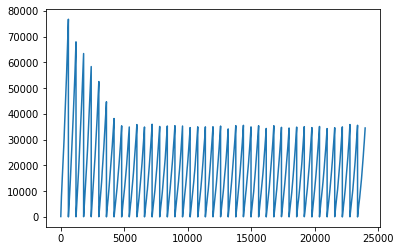

In [26]:
plt.plot(loss_trend)

In [27]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [28]:
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
ruler = EntityRuler(nlp).from_disk("patterns_2020_02_08.jsonl")
nlp.add_pipe(ruler, before='ner')
nlp.pipe_names

['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [0]:
nlp.to_disk('trained_model_2020_02_08')

In [1]:
pwd

'/content'

In [0]:
nlp = spacy.load('trained_model_2020_02_08')

In [33]:
ent_list_eval = []
for doc in nlp.pipe(eval_reviews['text']):
#  displacy.render(nlp(doc),'ent',jupyter=True)
  ent_list_eval.append([k  for k in Counter(sorted([(ent.ent_id_) for ent in doc.ents if ent.ent_id_ != ''])).keys()])
#ent_list.append([ent.text for ent in nlp(doc).ents if ent.ent_id_ == ''])

ent_list_eval[-5:]

[['$_25',
  '2',
  'carrots',
  'cottage_cheese',
  'cucumber',
  'dinner',
  'lunch',
  'mushrooms',
  'persian_rice',
  'pita',
  'red_peppers',
  'salad',
  'vegetable',
  'zucchini'],
 ['baklava', 'nuts', 'pastry', 'syrup'],
 ['$_2',
  '3',
  'beans',
  'brown_rice',
  'burrito_bowl',
  'cheese',
  'guacamole',
  'gyg',
  'jalapeños',
  'meat',
  'mexican',
  'parsley',
  'rice',
  'salsa',
  'singapore',
  'tortilla_chips',
  'vegan',
  'vegetable',
  'vegetarian'],
 ['arugula',
  'bun',
  'burger',
  'crisp',
  'dairy_free',
  'half',
  'pumpkin_seed',
  'sautéed_mushrooms',
  'vegan'],
 ['falafel_wrap',
  'garlic',
  'garlic_spread',
  'olive_oil',
  'salad',
  'spice',
  'sweet_potato_fries',
  'tabbouleh',
  'vegan',
  'wrap']]

In [34]:
ent_list_eval[:5]

[['vegan'],
 ['garbanzo', 'hamburger'],
 ['basil', 'cashew_nuts', 'cherry_tomatoes', 'pasta', 'tea'],
 [],
 ['milanesa']]

In [0]:
df_entities = pd.DataFrame(pd.Series(ent_list_eval),columns=['entities'])

In [0]:
df_entities.to_csv('entities_3_93k.csv',index=False)

In [37]:
df_entities.tail()

,entities
89791,"[$_25, 2, carrots, cottage_cheese, cucumber, d..."
89792,"[baklava, nuts, pastry, syrup]"
89793,"[$_2, 3, beans, brown_rice, burrito_bowl, chee..."
89794,"[arugula, bun, burger, crisp, dairy_free, half..."
89795,"[falafel_wrap, garlic, garlic_spread, olive_oi..."


In [38]:
eval_reviews.reset_index(drop=True)

,_id,likes,user,text,type,restaurant,dish,taste,presentation,nutrition,originality,value,overall,createdAt,user_info.name,user_info.likedArticlesCount,user_info.followersCount,user_info.likedReviewsCount,user_info.challengeReviews,user_info.username,user_info.language,user_info.home,user_info.reviewKarma.total.score,dish_info.name,restaurant_name,restaurant_country,restaurant_website,restaurant_locality
0,5e2f312ee873b10020b64c5d,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...",5e09716a3a202700209d8f8d,Mitad cancha mitad super cancha (con queso veg...,dish,5c6f728176f4630004a9926b,5db821535168bd0020e738ca,5,5,5,5,5,5.0,2020-01-27 18:51:26.422,germancampagno,0,11,19,13,germancampagno,en,Argentina,40,Pizza con paparella,Pizzas y Empanadas IL Giardino De Devoto,Argentina,https://www.facebook.com/ilgiardinodidevoto/,NaN
1,5e2f30cd21cbcd002090abdd,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...",5def888d287cf90020c983dc,Hamburguesa de porotos o de garbanzos con ques...,dish,5c78e1f22fc7720004d832eb,5e2f30cd21cbcd002090abdc,5,5,4,4,4,4.4,2020-01-27 18:49:49.544,Estefa,0,1,1,7,wicca,es,Chile,7,Hamburguesa cheddar,Rincón Flamenco Café,Chile,NaN,La Serena
2,5e2f30c521cbcd002090abd4,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...",5e1a06a6ce56f60020488a73,Creamy and elegant pasta with cherry tomatoes ...,dish,5a067976989c390004ffc1ce,5e2f30c3e873b10020b64c4c,5,5,5,4,5,4.8,2020-01-27 18:49:41.422,anitagmer,0,2,0,8,anitagmer,es,Spain,8,Pasta Alfredo,Veda House,Bulgaria,http://vedahouse.business.site/,Sofia
3,5e2f305d21cbcd002090abaf,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...",5e09716a3a202700209d8f8d,Despues del green doner es lo mas rico que pro...,dish,5c6fb05476f4630004a9979b,5d4c38082d8bea0004054003,5,5,3,5,3,4.2,2020-01-27 18:47:57.080,germancampagno,0,11,19,13,germancampagno,en,Argentina,40,Green Steak,GreenFactory,Argentina,http://www.greenfactory.com.ar/,NaN
4,5e2f3021e873b10020b64c1a,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...",5e09716a3a202700209d8f8d,"Jamon queso huevo milanesa, de todo 🤯🤯🤯🤯🤯🤯🤯",dish,5d36712b49745d0004c69f05,5d43224660309900045dbd46,5,5,3,5,5,4.6,2020-01-27 18:46:57.667,germancampagno,0,11,19,13,germancampagno,en,Argentina,40,Lomito completo,Loving Hut Microcentro,Argentina,https://www.facebook.com/LovingHut.Microcentro/,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89791,59d44b0772199b0004e14a9a,"[ObjectId('59cb241c92c3c5000471f99e'), ObjectI...",59c489e73e616a0004f9bcf7,The best grilled vegetable plate I've ever had...,dish,59d445ab35cce100043233af,59d44b0672199b0004e14a99,5,4,4,4,3,4.0,2017-10-04 02:44:23.439,Vikas Garg,153,696,8637,37,vikas,en,Singapore,661,Sabzi Kebab,Shabestan,Singapore,http://www.shabestan.sg/,Singapore
89792,59d1f1658ea122000471905b,[],59cb241c92c3c5000471f99e,One of the best baklava I've had as it was not...,dish,59cb26a292c3c5000471f99f,59d1f0db8ea1220004719057,5,5,5,4,4,4.6,2017-10-02 07:57:25.472,honey-bee nya,0,11,63,0,nakahara,NaN,Singapore,2,Baklava,Urban Bites,Singapore,http://www.urbanbites.com.sg/,Singapore
89793,59cb5ca192c3c5000471f9c9,[ObjectId('5ac488841aa1140004b06fc1')],59b0a60c3c31d00004d97fa2,Protip: get the vegetarian version of the burr...,dish,59cb5a0f92c3c5000471f9b7,59cb5b8a92c3c5000471f9b8,5,4,5,4,4,4.4,2017-09-27 08:09:05.837,Alaine Johnson,76,198,1930,7,alaine,en,Singapore,273,Vegetarian Burrito Bowl,Guzman Y Gomez,Singapore,http://www.gyg.com.sg/,Singapore
89794,59cb59dc92c3c5000471f9b5,[],59b0a60c3c31d00004d97fa2,This dish is clearly labeled with a green leaf...,dish,59cb576a92c3c5000471f9b2,59cb59db92c3c5000471f9b4,5,4,5,4,4,4.4,2017-09-27 07:57:16.062,Alaine Johnson,76,198,1930,7,alaine,en,Singapore,273,Vegan Arugula Mushroom Burger,Tiong Bahru Bakery,Singapore,http://www.tiongbahrubakery.com/,Singapore


In [39]:
eval_new_df = pd.concat([eval_reviews.reset_index(drop=True), df_entities],axis=1,ignore_index=True)
eval_new_df.columns = list(eval_reviews.columns) + list(df_entities.columns)
eval_new_df.head()

,_id,likes,user,text,type,restaurant,dish,taste,presentation,nutrition,originality,value,overall,createdAt,user_info.name,user_info.likedArticlesCount,user_info.followersCount,user_info.likedReviewsCount,user_info.challengeReviews,user_info.username,user_info.language,user_info.home,user_info.reviewKarma.total.score,dish_info.name,restaurant_name,restaurant_country,restaurant_website,restaurant_locality,entities
0,5e2f312ee873b10020b64c5d,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...",5e09716a3a202700209d8f8d,Mitad cancha mitad super cancha (con queso veg...,dish,5c6f728176f4630004a9926b,5db821535168bd0020e738ca,5,5,5,5,5,5.0,2020-01-27 18:51:26.422,germancampagno,0,11,19,13,germancampagno,en,Argentina,40,Pizza con paparella,Pizzas y Empanadas IL Giardino De Devoto,Argentina,https://www.facebook.com/ilgiardinodidevoto/,NaN,[vegan]
1,5e2f30cd21cbcd002090abdd,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...",5def888d287cf90020c983dc,Hamburguesa de porotos o de garbanzos con ques...,dish,5c78e1f22fc7720004d832eb,5e2f30cd21cbcd002090abdc,5,5,4,4,4,4.4,2020-01-27 18:49:49.544,Estefa,0,1,1,7,wicca,es,Chile,7,Hamburguesa cheddar,Rincón Flamenco Café,Chile,NaN,La Serena,"[garbanzo, hamburger]"
2,5e2f30c521cbcd002090abd4,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...",5e1a06a6ce56f60020488a73,Creamy and elegant pasta with cherry tomatoes ...,dish,5a067976989c390004ffc1ce,5e2f30c3e873b10020b64c4c,5,5,5,4,5,4.8,2020-01-27 18:49:41.422,anitagmer,0,2,0,8,anitagmer,es,Spain,8,Pasta Alfredo,Veda House,Bulgaria,http://vedahouse.business.site/,Sofia,"[basil, cashew_nuts, cherry_tomatoes, pasta, tea]"
3,5e2f305d21cbcd002090abaf,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...",5e09716a3a202700209d8f8d,Despues del green doner es lo mas rico que pro...,dish,5c6fb05476f4630004a9979b,5d4c38082d8bea0004054003,5,5,3,5,3,4.2,2020-01-27 18:47:57.080,germancampagno,0,11,19,13,germancampagno,en,Argentina,40,Green Steak,GreenFactory,Argentina,http://www.greenfactory.com.ar/,NaN,[]
4,5e2f3021e873b10020b64c1a,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...",5e09716a3a202700209d8f8d,"Jamon queso huevo milanesa, de todo 🤯🤯🤯🤯🤯🤯🤯",dish,5d36712b49745d0004c69f05,5d43224660309900045dbd46,5,5,3,5,5,4.6,2020-01-27 18:46:57.667,germancampagno,0,11,19,13,germancampagno,en,Argentina,40,Lomito completo,Loving Hut Microcentro,Argentina,https://www.facebook.com/LovingHut.Microcentro/,NaN,[milanesa]


In [40]:
ent_list_eval_tba = []
for doc in nlp.pipe(eval_reviews['text']):
  ent_list_eval_tba.append([ent.text for ent in doc.ents if ent.ent_id_ == ''])

df_eval = pd.DataFrame()
df_eval = df_eval.append(ent_list_eval_tba).dropna(how='all')

full_list_eval_tba = []

for col in df_eval.columns:
  full_list_eval_tba.extend([k.lower() for k in Counter(list(df_eval[col])).keys() if k != None])

full_list_eval_tba = [k for k in Counter(sorted(full_list_eval_tba)).keys()]
len(full_list_eval_tba)

1651

In [41]:
ent_list_test_tba = []
for doc in nlp.pipe(test_reviews['text']):
  ent_list_test_tba.append([ent.text for ent in doc.ents if ent.ent_id_ == ''])

df_test = pd.DataFrame()
df_test = df_test.append(ent_list_test_tba).dropna(how='all')

full_list_test_tba = []

for col in df_test.columns:
  full_list_test_tba.extend([k.lower() for k in Counter(list(df_test[col])).keys() if k != None])

full_list_test_tba = [k for k in Counter(sorted(full_list_test_tba)).keys()]
len(full_list_test_tba)

0

In [42]:
entities_to_be_added = [k for k in Counter(sorted(full_list_eval_tba + full_list_test_tba)).keys()]
len(entities_to_be_added)

1651

In [0]:
pat_list = list(df_pattern['id'].unique())

In [44]:
leven_result = []
for inp in entities_to_be_added:

  for pat in pat_list:
    leven = td.levenshtein.normalized_similarity(inp, pat)

    if  (leven > 0.7) & (leven < 0.9999):
      leven_result.append((inp, pat, leven))
len(leven_result)

936

In [45]:
sound_list = [item for item in entities_to_be_added if type(item) == str]
soundex_list = []

for item in sound_list:
  try:
    soundx = jf.soundex(item)
  except:
    soundx = 'no value'
  soundex_list.append((item, soundx))

len(soundex_list)

1651

In [46]:
soundex_list

[('+0.20', '+000'),
 (', few', ',100'),
 ('-hour', '-600'),
 ('.ricotta  ', '.623'),
 ('0/10', '0000'),
 ('1.000', '1000'),
 ('10.40sgd', '1230'),
 ('1000/10', '1000'),
 ('100zaront', '1265'),
 ('10pcs', '1120'),
 ('11,50', '1000'),
 ('11:30', '1000'),
 ('12-jan', '1250'),
 ('12.90', '1000'),
 ('13,000', '1000'),
 ('130zaront', '1265'),
 ('14/11', '1000'),
 ('1920s', '1200'),
 ('1924', '1000'),
 ('1941', '1000'),
 ('1942', '1000'),
 ('1:00', '1000'),
 ('1:30', '1000'),
 ('1;trozo', '1362'),
 ('1for1', '1160'),
 ('1x', '1200'),
 ('1€.', '1000'),
 ('2/4', '2000'),
 ('20days', '2320'),
 ('22', '2000'),
 ('22 hours', '2620'),
 ('24 hours', '2620'),
 ('24 hrs', '2620'),
 ('2:30', '2000'),
 ('3-day', '3300'),
 ('3/11', '3000'),
 ('30mins', '3552'),
 ('3s', '3200'),
 ('3th', '3300'),
 ('45++', '4000'),
 ('49', '4000'),
 ('4:30', '4000'),
 ('4p', '4100'),
 ('5-spice', '5212'),
 ('5.000', '5000'),
 ('50pe', '5100'),
 ('5sg$', '5200'),
 ('7/11', '7000'),
 ('70kr', '7260'),
 ('71', '7000'),
 ('8.

In [47]:
leven_result.sort(key=lambda x: x[0])
leven_result

[('0/10', '10/10', 0.8),
 ('0/10', '20/10', 0.8),
 ('0/10', '3/10', 0.75),
 ('0/10', '4/10', 0.75),
 ('0/10', '5/10', 0.75),
 ('0/10', '6/10', 0.75),
 ('0/10', '7/10', 0.75),
 ('0/10', '8/10', 0.75),
 ('0/10', '9/10', 0.75),
 ('1.000', '1000', 0.8),
 ('1.000', '10000', 0.8),
 ('1000/10', '10000', 0.7142857142857143),
 ('1000/10', '10/10', 0.7142857142857143),
 ('1000/10', '100/10', 0.8571428571428572),
 ('1:00', '1000', 0.75),
 ('1:00', '100', 0.75),
 ('1:00', '5:00', 0.75),
 ('1:30', '5:30', 0.75),
 ('1:30', '7:30', 0.75),
 ('24 hours', '24_hour', 0.75),
 ('2:30', '5:30', 0.75),
 ('2:30', '7:30', 0.75),
 ('3/11', '3/10', 0.75),
 ('30mins', '10_mins', 0.7142857142857143),
 ('30mins', '20_mins', 0.7142857142857143),
 ('30mins', '90_mins', 0.7142857142857143),
 ('3th', '13th', 0.75),
 ('3th', '30th', 0.75),
 ('4:30', '5:30', 0.75),
 ('4:30', '7:30', 0.75),
 ('5-spice', 'spice', 0.7142857142857143),
 ('5.000', '50000', 0.8),
 ('50pe', '50p', 0.75),
 ('7/11', '7/10', 0.75),
 ('a hour', 'an

In [2]:
leven_result

NameError: ignored

In [48]:
dump_jsonl(entities_to_be_added,'entities_to_be_added.jsonl')
dump_jsonl(leven_result,'leven_similar.jsonl')
dump_jsonl(soundex_list,'sound_similar.jsonl')

Wrote 1651 records to entities_to_be_added.jsonl
Wrote 936 records to leven_similar.jsonl
Wrote 1651 records to sound_similar.jsonl


In [0]:
dump_jsonl(entities_to_be_added,'entities_to_be_added.jsonl')
dump_jsonl(leven_result,'leven_similar.jsonl')
dump_jsonl(soundex_list,'sound_similar.jsonl')

In [0]:
with open('entities_to_be_added_test.csv', 'w') as f:
    f.write(json.dumps(entities_to_be_added))

with open('most_similar_patterns.csv', 'w') as f:
    f.write(json.dumps(leven_result))

with open('most_similar_sounding_patterns.csv', 'w') as f:
    f.write(json.dumps(soundex_list))

In [0]:
eval_new_df.columns

Index(['_id', 'likes', 'user', 'text', 'type', 'restaurant', 'dish', 'taste',
       'presentation', 'nutrition', 'originality', 'value', 'overall',
       'createdAt', 'user_info.name', 'user_info.likedArticlesCount',
       'user_info.followersCount', 'user_info.likedReviewsCount',
       'user_info.challengeReviews', 'user_info.username',
       'user_info.language', 'user_info.home',
       'user_info.reviewKarma.total.score', 'dish_info.name',
       'restaurant_name', 'restaurant_country', 'restaurant_website',
       'restaurant_locality', 'entities'],
      dtype='object')

In [0]:
eval_new_df.columns = ['review', 'likes', 'user', 'text', 'type', 'restaurant', 'dish', 'taste',\
                       'presentation', 'nutrition', 'originality', 'value', 'overall',\
                       'createdAt', 'name', 'likedArticlesCount', 'followersCount',\
                       'likedReviewsCount','challengeReviews', 'username', 'language','home',\
                       'reviewKarma_score', 'dish_name', 'restaurant_name', 'restaurant_country', \
                       'restaurant_website', 'restaurant_locality', 'entities']

In [0]:
df_likes = eval_new_df[['review','likes']]
df_likes['cleaned_likes'] = df_likes['likes'].apply(lambda x: clean_like_objects(x))
df_likes.head()

,review,likes,cleaned_likes
0,5e2f312ee873b10020b64c5d,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...","[5e03e8307956290020e51e8d, 5e1bb2793c198000200..."
1,5e2f30cd21cbcd002090abdd,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...","[5e03e8307956290020e51e8d, 5c748a8934dda90004b..."
2,5e2f30c521cbcd002090abd4,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...","[5e03e8307956290020e51e8d, 5b1c9c020e466900047..."
3,5e2f305d21cbcd002090abaf,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...","[5e03e8307956290020e51e8d, 5c748a8934dda90004b..."
4,5e2f3021e873b10020b64c1a,"[ObjectId('5e03e8307956290020e51e8d'), ObjectI...","[5e03e8307956290020e51e8d, 5c748a8934dda90004b..."


In [0]:
df_likes['likes'] = df_likes.cleaned_likes.apply(lambda x: x[1:-1].split(','))
df_likes.head()

,review,likes,cleaned_likes
0,5e2f312ee873b10020b64c5d,"[5e03e8307956290020e51e8d, 5e1bb2793c19800020...","[5e03e8307956290020e51e8d, 5e1bb2793c198000200..."
1,5e2f30cd21cbcd002090abdd,"[5e03e8307956290020e51e8d, 5c748a8934dda90004...","[5e03e8307956290020e51e8d, 5c748a8934dda90004b..."
2,5e2f30c521cbcd002090abd4,"[5e03e8307956290020e51e8d, 5b1c9c020e46690004...","[5e03e8307956290020e51e8d, 5b1c9c020e466900047..."
3,5e2f305d21cbcd002090abaf,"[5e03e8307956290020e51e8d, 5c748a8934dda90004...","[5e03e8307956290020e51e8d, 5c748a8934dda90004b..."
4,5e2f3021e873b10020b64c1a,"[5e03e8307956290020e51e8d, 5c748a8934dda90004...","[5e03e8307956290020e51e8d, 5c748a8934dda90004b..."


In [0]:
df_likes = df_likes[['review','likes']].explode('likes').reset_index(drop=True)

In [0]:
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372733 entries, 0 to 372732
Data columns (total 2 columns):
review    372733 non-null object
likes     372733 non-null object
dtypes: object(2)
memory usage: 5.7+ MB


In [0]:
df_likes.columns = ['review','user']
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372733 entries, 0 to 372732
Data columns (total 2 columns):
review    372733 non-null object
user      372733 non-null object
dtypes: object(2)
memory usage: 5.7+ MB


In [0]:
df_likes[df_likes['user']==''] = np.nan
df_likes.dropna(inplace=True)
df_likes.head()

,review,user
0,5e2f312ee873b10020b64c5d,5e03e8307956290020e51e8d
1,5e2f312ee873b10020b64c5d,5e1bb2793c198000200848ee
2,5e2f30cd21cbcd002090abdd,5e03e8307956290020e51e8d
3,5e2f30cd21cbcd002090abdd,5c748a8934dda90004b017b4
4,5e2f30c521cbcd002090abd4,5e03e8307956290020e51e8d


In [0]:
df_likes.info()
df_likes.drop_duplicates(inplace=True)
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368472 entries, 0 to 372732
Data columns (total 2 columns):
review    368472 non-null object
user      368472 non-null object
dtypes: object(2)
memory usage: 8.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 284277 entries, 0 to 372732
Data columns (total 2 columns):
review    284277 non-null object
user      284277 non-null object
dtypes: object(2)
memory usage: 6.5+ MB


In [0]:
df_keyword_ents = pd.read_json('patterns_2020_02_08.jsonl',lines=True)[['id','label']].drop_duplicates().reset_index(drop=True)
df_keyword_ents.head()

,id,label
0,algerian_coffee,beverage
1,almond_milk,beverage
2,almond_latte,beverage
3,arabic_coffee,beverage
4,arrack,beverage


In [0]:
df_keyword_ents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20943 entries, 0 to 20942
Data columns (total 2 columns):
id       20943 non-null object
label    20943 non-null object
dtypes: object(2)
memory usage: 327.4+ KB


In [0]:
df_keyword_ents['updated'] = df_keyword_ents['label'].apply(lambda x: x+'_') + df_keyword_ents['id']
df_keyword_ents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20943 entries, 0 to 20942
Data columns (total 3 columns):
id         20943 non-null object
label      20943 non-null object
updated    20943 non-null object
dtypes: object(3)
memory usage: 491.0+ KB


In [0]:
df_keyword_ents.columns = ['keyword_name', 'keyword_class', 'keyword_id']
df_keyword_ents.head()

,keyword_name,keyword_class,keyword_id
0,algerian_coffee,beverage,beverage_algerian_coffee
1,almond_milk,beverage,beverage_almond_milk
2,almond_latte,beverage,beverage_almond_latte
3,arabic_coffee,beverage,beverage_arabic_coffee
4,arrack,beverage,beverage_arrack


In [0]:
df_dish_keywords = eval_new_df[['dish','dish_name','entities']].explode('entities').reset_index(drop=True)
df_dish_keywords.info()
df_dish_keywords.dropna(inplace=True)
df_dish_keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341215 entries, 0 to 341214
Data columns (total 3 columns):
dish         341215 non-null object
dish_name    341215 non-null object
entities     332391 non-null object
dtypes: object(3)
memory usage: 7.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 332391 entries, 0 to 341214
Data columns (total 3 columns):
dish         332391 non-null object
dish_name    332391 non-null object
entities     332391 non-null object
dtypes: object(3)
memory usage: 10.1+ MB


In [0]:
df_dish_keywords=df_dish_keywords.merge(df_keyword_ents,how='left',left_on='entities',right_on='keyword_name').drop(columns=['keyword_name'])
df_dish_keywords.columns=['dish','dish_name','keyword_name','keyword_class','keyword_id']
df_dish_keywords.head()

,dish,dish_name,keyword_name,keyword_class,keyword_id
0,5db821535168bd0020e738ca,Pizza con paparella,vegan,lifestyle,lifestyle_vegan
1,5e2f30cd21cbcd002090abdc,Hamburguesa cheddar,garbanzo,vegetable,vegetable_garbanzo
2,5e2f30cd21cbcd002090abdc,Hamburguesa cheddar,hamburger,dish,dish_hamburger
3,5e2f30c3e873b10020b64c4c,Pasta Alfredo,basil,herb,herb_basil
4,5e2f30c3e873b10020b64c4c,Pasta Alfredo,cashew_nuts,seed,seed_cashew_nuts


In [0]:
df_dish_keywords.info()
df_dish_keywords.drop_duplicates(inplace=True)

df_dish_keywords.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 335064 entries, 0 to 335063
Data columns (total 5 columns):
dish             335064 non-null object
dish_name        335064 non-null object
keyword_name     335064 non-null object
keyword_class    335064 non-null object
keyword_id       335064 non-null object
dtypes: object(5)
memory usage: 15.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 234108 entries, 0 to 335061
Data columns (total 5 columns):
dish             234108 non-null object
dish_name        234108 non-null object
keyword_name     234108 non-null object
keyword_class    234108 non-null object
keyword_id       234108 non-null object
dtypes: object(5)
memory usage: 10.7+ MB


In [0]:
df_dish_keywords.tail()

,dish,dish_name,keyword_name,keyword_class,keyword_id
335056,59cb53d992c3c5000471f9aa,Spicy Falafel Wrap,garlic_spread,condiment,condiment_garlic_spread
335057,59cb53d992c3c5000471f9aa,Spicy Falafel Wrap,olive_oil,condiment,condiment_olive_oil
335058,59cb53d992c3c5000471f9aa,Spicy Falafel Wrap,salad,dish,dish_salad
335059,59cb53d992c3c5000471f9aa,Spicy Falafel Wrap,spice,spice,spice_spice
335061,59cb53d992c3c5000471f9aa,Spicy Falafel Wrap,tabbouleh,dish,dish_tabbouleh


In [0]:
df_GPE_keywords = df_dish_keywords.query('keyword_class in ["GPE_city","GPE_region","GPE_country"]')
df_GPE_keywords.info()

df_GPE_keywords.to_csv('gpe_keywords.csv',index=False)


df_dish_keywords.query('keyword_class == "GPE_city"').to_csv('gpe_keywords_city.csv',index=False)
df_dish_keywords.query('keyword_class == "GPE_region"').to_csv('gpe_keywords_region.csv',index=False)
df_dish_keywords.query('keyword_class == "GPE_country"').to_csv('gpe_keywords_country.csv',index=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5693 entries, 11 to 335040
Data columns (total 5 columns):
dish             5693 non-null object
dish_name        5693 non-null object
keyword_name     5693 non-null object
keyword_class    5693 non-null object
keyword_id       5693 non-null object
dtypes: object(5)
memory usage: 266.9+ KB


In [0]:
df_dish_keywords.query('keyword_class == "partner"').to_csv('dish_partner.csv',index=False)

In [0]:
df_dish_keywords.query('keyword_class == "partner"')

,dish,dish_name,keyword_name,keyword_class,keyword_id
134,5e2ee89721cbcd002090a019,"Crema de col, espinaca y coliflor",fundación_santuario_gaia,partner,partner_fundación_santuario_gaia
140,5e2ee6e5e873b10020b64055,Wok,el_paraiso_de_los_animales,partner,partner_el_paraiso_de_los_animales
161,5e2ee68e21cbcd0020909fa5,Frushi Hot,el_paraiso_de_los_animales,partner,partner_el_paraiso_de_los_animales
1062,5e2dfe4afa045e002047d470,Cazuela De Verduras,el_hogar_animal_sanctuary,partner,partner_el_hogar_animal_sanctuary
1064,5e2dfe0efa045e002047d46a,Variedad De Entrantes,el_hogar_animal_sanctuary,partner,partner_el_hogar_animal_sanctuary
...,...,...,...,...,...
332974,5a387803e25030000437a255,Singapore Laksa (vegan),center_for_responsible_future,partner,partner_center_for_responsible_future
332997,5a375d53727bfc00042da1e8,Organic bee hoon ‘fish’ seaweed soup,center_for_responsible_future,partner,partner_center_for_responsible_future
333091,5a364a74587eb70004fab238,Fried Kway Teow,center_for_responsible_future,partner,partner_center_for_responsible_future
333327,5a33a04ad43f27000440e2a5,Kutscher - Spicy Patty with grilled vegetable ...,center_for_responsible_future,partner,partner_center_for_responsible_future


In [0]:
df_dish_keywords.query('keyword_class not in ["GPE_city","GPE_region","GPE_country"]').to_csv('dish_keywords.csv',index=False)

In [0]:
eval_new_df.to_csv('eval_new_graph_input.csv',index=False)

In [0]:
df_dish_keywords.query('keyword_class=="GPE_city"')['keyword_name'].value_counts()

barcelona    56
portland     42
tomar        38
denver       36
paris        36
             ..
acapulco      1
miramar       1
murrieta      1
raleigh       1
nanyang       1
Name: keyword_name, Length: 452, dtype: int64

In [0]:
df_dish_keywords.query('keyword_class=="GPE_country"')['keyword_name'].value_counts()

singapore    525
india        100
hong_kong     93
japan         90
chile         66
            ... 
bolivia        1
romania        1
tunisia        1
armenia        1
slovakia       1
Name: keyword_name, Length: 82, dtype: int64

In [0]:
df_dish_keywords.query('keyword_class=="GPE_region"')['keyword_name'].value_counts()

bali            96
london          93
new_york        86
sichuan         79
van             72
                ..
azores           1
illinois         1
cundinamarca     1
zürich           1
hessen           1
Name: keyword_name, Length: 276, dtype: int64

In [0]:
pd.DataFrame(df_pattern.query('label == "U_GPE_country"')['id'].drop_duplicates().reset_index(drop=True)).to_csv('country_list.csv',index=False)
pd.DataFrame(df_pattern.query('label == "U_GPE_region"')['id'].drop_duplicates().reset_index(drop=True)).to_csv('admin_list.csv',index=False)
pd.DataFrame(df_pattern.query('label == "U_GPE_city"')['id'].drop_duplicates().reset_index(drop=True)).to_csv('city_list.csv',index=False)

In [0]:
eval_new_df.columns

Index(['review', 'likes', 'user', 'text', 'type', 'restaurant', 'dish',
       'taste', 'presentation', 'nutrition', 'originality', 'value', 'overall',
       'createdAt', 'name', 'likedArticlesCount', 'followersCount',
       'likedReviewsCount', 'challengeReviews', 'username', 'language', 'home',
       'reviewKarma_score', 'dish_name', 'restaurant_name',
       'restaurant_country', 'restaurant_website', 'restaurant_locality',
       'entities'],
      dtype='object')

In [0]:
eval_new_df[['user','username','name','likedArticlesCount',\
             'followersCount', 'likedReviewsCount',\
             'challengeReviews', 'language', 'home',\
             'reviewKarma_score']].drop_duplicates().reset_index(drop=True).to_csv('user_detail.csv',index=False)
eval_new_df[['dish','dish_name']].drop_duplicates().reset_index(drop=True).to_csv('dish_detail.csv',index=False)
eval_new_df[['restaurant','restaurant_name', \
             'restaurant_country','restaurant_website',\
             'restaurant_locality']].drop_duplicates().reset_index(drop=True).to_csv('rest_detail.csv',index=False)
eval_new_df[['review','originality', 'value', \
             'nutrition','presentation', \
             'taste', 'overall','createdAt','type']].drop_duplicates().reset_index(drop=True).to_csv('rev_detail.csv',index=False)
df_keyword_ents.to_csv('keyword_detail.csv',index=False)

In [0]:
eval_new_df[['dish','restaurant']].drop_duplicates().reset_index(drop=True).to_csv('dish_restaurant.csv',index=False)
eval_new_df[['user','review']].drop_duplicates().reset_index(drop=True).to_csv('user_review.csv',index=False)
eval_new_df[['dish','review']].drop_duplicates().reset_index(drop=True).to_csv('dish_review.csv',index=False)
df_likes.drop_duplicates().reset_index(drop=True).to_csv('rev_user_likes.csv',index=False)

In [0]:
df_likes.head()

,review,user
0,5e2f312ee873b10020b64c5d,5e03e8307956290020e51e8d
1,5e2f312ee873b10020b64c5d,5e1bb2793c198000200848ee
2,5e2f30cd21cbcd002090abdd,5e03e8307956290020e51e8d
3,5e2f30cd21cbcd002090abdd,5c748a8934dda90004b017b4
4,5e2f30c521cbcd002090abd4,5e03e8307956290020e51e8d


In [0]:
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284277 entries, 0 to 372732
Data columns (total 2 columns):
review    284277 non-null object
user      284277 non-null object
dtypes: object(2)
memory usage: 6.5+ MB


In [0]:
review_likes_series_count = df_likes.groupby('review')['user'].count()

In [0]:
review_likes_series_count.mean()

4.104549589223061

In [0]:
review_likes_series_count.max()

45

In [0]:
review_likes_series_count.median()

3.0

(array([1.0352e+04, 1.3518e+04, 1.2950e+04, 9.9900e+03, 7.2140e+03,
        4.7980e+03, 3.1630e+03, 2.0880e+03, 0.0000e+00, 1.4630e+03,
        8.9200e+02, 6.6800e+02, 4.4900e+02, 3.5600e+02, 2.7600e+02,
        2.1200e+02, 0.0000e+00, 1.7300e+02, 1.1500e+02, 1.0000e+02,
        9.1000e+01, 6.0000e+01, 4.5000e+01, 3.7000e+01, 0.0000e+00,
        3.7000e+01, 3.5000e+01, 4.4000e+01, 3.3000e+01, 2.2000e+01,
        1.5000e+01, 1.8000e+01, 8.0000e+00, 0.0000e+00, 8.0000e+00,
        1.1000e+01, 6.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1.  ,  1.88,  2.76,  3.64,  4.52,  5.4 ,  6.28,  7.16,  8.04,
         8.92,  9.8 , 10.68, 11.56, 12.44, 13.32, 14.2 , 15.08, 15.96,
        16.84, 17.72, 18.6 , 19.48, 20.36, 21.24, 22.12, 23.  , 23.88,
        24.76, 25.64, 26.52, 27.4 , 28.28, 29.16, 30.04, 30.92, 31.8 ,
        32.68, 33.56, 34.44, 35.32

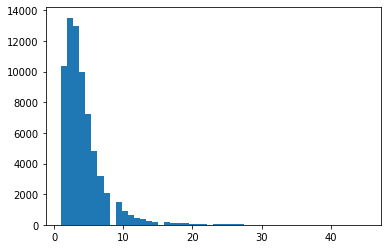

In [0]:
plt.hist(review_likes_series_count,bins=50)

In [0]:
review_likes_series_count.count()

69259